# KOIOS
* Detecting the heart rate of a patient using signal processing and machine learning
* Project number: 87
* By Perry Tubul 205874290 and Eyal Golan 204229223

# Table of Contents
1. [Advanced engine implementation](#Advanced)
2. [Setup](#Setup)
3. [Engine](#Engine)
4. [HR detection](#hr)

# <a class="anchor" id="Advanced">1. Advanced engine implementation</a>
Using a similar logic as the basic engine, with the following changes for better results:
* Wavelet based Multivariate De-noising -
* MTCNN neural network - in order to detect the regions of intrest of a moving patient
* luminance detection and manipulation for more accurate heart rate results - used mainly when there are changing or bad
 lightning conditions

# <a class="anchor" id="Setup">2. Setup</a>
#### Initializing the Logger and the MTCNN neural networks, reading the videos location and detecting the OS

In [1]:
from facenet_pytorch import MTCNN #for detecting ROI of a moving subject
import torch
import face_recognition, PIL.Image, PIL.ImageDraw,math
import logging
import cv2
import platform
import scipy.signal as sig
import os
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
import numpy as np
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import sys

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

with open("input_path.txt") as input_file:
    input_location = input_file.read()
pattern = ".avi"
video_sources = []

for path, subdirs, files in os.walk(input_location):
    for name in files:
        if name.endswith(pattern):
            video_sources.append(os.path.join(path, name))

logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"


# since MTCNN is a collection of neural nets and other code, the device must be passed
# in the following way to enable copying of objects when needed internally
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)


[2021-08-01 19:38:07,228] [INFO] [<module>] [30] : Starting ...


In [2]:
#%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

# <a class="anchor" id="Engine">3. Engine</a>
## 3.1 ROI detection
Detects face landmarks and parsing the ROI

In [3]:
def detect_face(frame):
    """
    Detect face in a frame
    :param frame: A video frame
    :return: the location of the face in the picture
    """
    face_locations_handle_motion = mtcnn.detect(frame) # using pre-trained model to find faces
    face_location = list() 
    face_location.append(float(face_locations_handle_motion[0][0][1]))
    face_location.append(float(face_locations_handle_motion[0][0][2]))
    face_location.append(float(face_locations_handle_motion[0][0][3]))
    face_location.append(float(face_locations_handle_motion[0][0][0]))
    face_locations = list()
    face_locations.append(face_location)
    return face_locations

def parse_roi(frame):
    """
    Find a face and its region of interests.  
    @param frame: A video frame
    @return: None in case of which no face was detected. A tuple in a form of (forehead, nose_to_upper_lip) 
    forehead is ndarray that represents the subject's forehead, nose_to_upper_lip is ndarray that represents the region
    between the upper lip and the nose of the subject. 
    """
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    try:
        face_locations = detect_face(frame)
    except Exception as e:
        logging.error("Failure in face detection, error: " + str(e))
        
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except Exception as e:
            logging.warning("No forehead found, " + str(e))
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except Exception as e:
            logging.warning("No left eyebrow found, " + str(e))
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except Exception as e:
            logging.warning("No upper mouth found, " + str(e))
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except Exception as e:
            logging.warning("No upper nose found, " + str(e))
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

## 3.2 Check for bad frames
* Criteria is:  R > 95 and G > 40 and B > 20 and R > G and R > B
* Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [4]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    """
        Checks the light conditions 
        @param: blue Is the mean of all the blue pixels in one frame
        @param: green Is the mean  of all the green pixels in one frame
        @param: red Is the mean of all the red pixels in one frame
        return False 0 meaning the lightning are bad, True when the lightning condition are OK
    """
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [5]:
def get_new_frame(vidcap):
    """
    Reads new video frame and return it.
    @param vidcap: Pointer to the video 
    @return True, Image where there is more frames in the video to be read else False, None 
    """
    success, next_image = vidcap.read()
    return success, next_image

## 3.3 Plotting RGB arrays

In [6]:
def plot_result(greens, reds, blues, x_value, title=""):
    """
    Generic function to plot graphs.
    @param greens: 1D array, greens[i] is the mean of all the green color in frame i 
    @param reds: 1D array, reds[i] is the mean of all the red color in frame i
    @param blues:1D array, blues[i] is the mean of all the blue color in frame i
    @param x_value: 1D array for the X- axis
    @param title: Title of the plot default is ""
    @return: None
    """
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

## 3.4 Channel filtering

In [7]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    try:
        channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    except Exception as e:
        logging.warning(str(e))
        return None
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

## 3.5 Get RGB values from a frame and Check light conditions

In [8]:
def parse_luminace(red, green, blue):
    """
    Calculate frame's luminace
    :param red: Mean value of all pixels in the red channel
    :param green: Mean value of all pixels in the green channel
    :param blue: Mean value of all pixels in the blue channel
    :return: The luminace value
    """
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level

def parse_RGB(rois, color_sig):
    """
    Calculate all the mean value of the green channel in ROI.
    :param roi: Area that we used to extract HR
    :param color_sig: is the the green signal thus far
    :return: False in case there is an error, color_sig and luminace value
    """
    for i,r in enumerate(rois):
        # extracting RGB colors from the frame
        red = r.getchannel(0)
        green = r.getchannel(1)
        blue = r.getchannel(2)
        b_mean,g_mean,r_mean = np.mean(blue),np.mean(green),np.mean(red)
        luminance_level = parse_luminace(r_mean, g_mean, b_mean)
        if good_frame(b_mean,g_mean,r_mean):
            #color_channels = r.reshape(-1, r.shape[-1])
            #avg_color = color_channels.mean(axis=0)
            color_sig[i].append(g_mean)
    return True, color_sig, luminance_level

## 3.6 Logging information about the video

In [9]:
def log_video_details(video_source):
    """
    Logging current video information
    :param video_source: Location of the current video that is being processed.
    :return: None
    """
    logging.info("\nInformation on video:\t\t\t\t\t\t" + str(video_source) +
                 "\nFPS:\t\t\t\t\t\t" + str(fps) + 
                 "\nRound FPS:\t\t\t\t\t\t" + str(round_fps) + 
                 "\nNumber of frames:\t\t\t\t" + str(number_of_frames) + 
                 "\nNumber of bad frames:\t\t\t\t" + str(bad_frames) + 
                 "\nMax luminanace:\t\t\t\t\t" + str(max_luminance) + 
                 "\nMin luminanace:\t\t\t\t\t" + str(min_luminance) +
                 "\nMax diff of luminanace between adjacent frames:\t" + str(max_diff_luminance_adjacent) +
                 "\nAvg luminanace:\t\t\t\t\t" + str(avg_luminance))

# <a class="anchor" id="hr">4. HR detection</a>
## 4.1 helper functions for HR detection - used to find the peaks in a given signal

In [10]:
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    """
    Finds the peaks in the signal
    :param y:  is the signal
    :param thres: minimum height of the peaks
    :param min_dist: minimum distance between each peek 
    :param thres_abs: 
    :return: array of all the peaks
    """
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

## 4.2 support functions for plotting the results

In [11]:
def print_results(frames_window, window, xlabel, ylabel, change_range, title):
    """
    Generic function that plots signals for a 30 seconds window
    @param frames_window: 1D array represent the seconds in the window 
    @param window:HR 30 seconds signal 
    @param xlabel: label to be shown in the X - axis
    @param ylabel: label to be shown in the Y - axis
    @param change_range:
    @return: None
    """
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.subplots()
    while len(frames_window) > len(window):
        frames_window = frames_window[:-1]
    ax.plot(frames_window,window,color ='green')
    if change_range:
        plt.xlim([0, 5])
    # add some data to the signal 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

def print_peaks_with_scipy(frames_window, window, round_fps, hr):
    """ 
    Find all the peaks in window
    :param frames_window: 1D array represent the seconds in the window 
    :param window: HR 30 seconds signal 
    :param round_fps: round frames per second
    :param hr: is the Heart rate 
    :return: None
    """ 
    while len(frames_window) > len(window):
        frames_window = frames_window[:-1]
    peaks, _ = sig.find_peaks(window, distance=round_fps)
    plt.plot(frames_window,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with scipy")
    plt.show()
    logging.info("Peaks vector with scipy: " + str(peaks) + " num of peaks: " + str(len(peaks)))

def print_peaks(frames_window, window):
    """
    Add a mark to all the peaks in window
    :param frames_window: 1D array represent the seconds in the window 
    :param window: 30 seconds signal 
    :return: 
    """
    while len(frames_window) > len(window):
        frames_window = frames_window[:-1]
    peaks = indexes(window,min_dist=20)
    plt.plot(frames_window,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with implemented function")
    plt.show()
    logging.info("Peaks vector by implemented function: " + str(frames_window[peaks]) + " num of peaks: " + str(len(frames_window[peaks])))
  

## 4.3 Split the signal into windows and find HR in each window

In [12]:
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    """
    Split the signal into windows and find HR in each window
    :param green: is the signal of the all video
    :param window_start: index of where the window start in green
    :param round_fps: round frames per seconds
    :param window_id: window number
    :param window_size: size of the window - 30 seconds or less if there are not enough frames
    :return: None
    """
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    frames_window = np.arange(window.size/round_fps,step= (1/round_fps))
    #plot the window:
    print_results(frames_window, window, 'X-axis', 'Y-axis', False, "Green signal")
    # normalize window signal
    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(frames_window, window, 'X-axis', 'Y-axis', False, "Green signal normalized")
    # filter the signal and plot results
    g = filter_channel(window,round_fps)
    if g is None: # An error occurred while filtering the signal
        return 
    print_peaks(frames_window, g)
    print_results(frames_window, window, 'X-axis', 'Y-axis', False, "")
    #plot the frequencies:
    f, Pxx_den = sig.periodogram(g, round_fps)
    print_results(f, Pxx_den, 'Frequency [Hz]', 'PSD [V**2/Hz]', True, "PSD by Frequency")
    # find the maximum freq.
    max_val = Pxx_den.argmax()
    logging.info("Window " + str(window_id) +
                 ":\nHighest freq:" + str(f[max_val]) + "\nHeart rate: " + str(f[max_val]*60))
    # find peaks - peak means breath
    print_peaks_with_scipy(frames_window, g,round_fps, f[max_val]*60)

## 4.4 DWT - Wavelet based Multivariate De-noising
* The de-noising of the multivariate signal is performed by removing the noise elements ε by
thresholding the noisy signals
* The heart beat is shifted to a frequency with lower power in the power spectral distribution (PSD).
* We estimated the heart rate by exploiting the periodicity of the PPG signal by a frequency based voting scheme

In [13]:
np.set_printoptions(threshold=sys.maxsize)
def eigenvalue_decomposition(mat):
    """
    Apply eigenvalue decomposition of the matrix mat
    :param mat: the matrix to apply the decomposition to.
    :return: diagonal matrix which consist of the eigenvalues of mat eigen vectors
    """
    eigen_vals, eigen_vectors = np.linalg.eigh(mat)
    d = np.diag(eigen_vals)
    return d,eigen_vectors

    
def multivariate_video_signal(signal):
    """
    Implementation of the algorithm from the paper.
    :param signal: is a 2D signal. One dimension the signal from the forehead, and second is from above the upper lip ( 1 dimension for each region in rois)
    :return: multivariate PPG as described in the paper.
    """    
     # convert the signal into vector
    sig1 = signal[0,:].T
    sig2 = signal[1,:].T
    n = len(sig1)
    wavelet = pywt.Wavelet('sym2') 
    # apply wavlet decomposition:
    c = pywt.wavedec(np.column_stack((sig1,sig2)),wavelet,level = 4,axis = 0)
    mcd = MCD(random_state = 0).fit(c[-1]).covariance_ # noise matrix
    V,D,VT = np.linalg.svd(mcd) # noise matrix decomposition
    lst = []
    pca = PCA(1) 
    comp = StandardScaler().fit_transform(c[0]) # normalize the features
    c[0] = comp
    comp = pca.fit_transform(comp)
    comp = np.column_stack((comp,comp))
    lst.append(comp)
    # Basis change 
    for i in range (1,len(c)): # the denoising
        x_i = np.dot(c[i],V)
        gama_0 = np.sqrt(2*np.log(n)*D[0])
        xi_0 = pywt.threshold(x_i[:,0],value= gama_0,mode='soft')
        gama_1 = np.sqrt(2*np.log(n)*D[1])
        xi_1 = pywt.threshold(x_i[:,1],value= gama_1,mode='soft')
        xi = np.column_stack((xi_0,xi_1))
        xi = xi@VT
        lst.append(xi)
    return pywt.waverec(lst,wavelet,axis = 0) # reconstruct 2d array

def mvd(color_sig):
    """
    Perfor mmultivariatee de-noising
    :param color_sig: is the HR signal with noise 
    :return: De-noise HR rate signal
    """
    ppg_hat = multivariate_video_signal(color_sig)
    return ppg_hat


## 4.5 Find HR estimation from the signal

In [14]:
def detect_hr(video_source):
    """
    Find HR estimation from the signal
    :param video_source: path to the video that is being procceesd
    :return: None
    """
    logging.info("\n=======================\n" + video_source + "\n=======================\n")
    color_sig_array = np.asarray(color_sig) # convert the signal to ndarray
    plt.figure(figsize=(15,6))
    plt.subplot(2,1,1)
    plt.plot(color_sig_array[0],"green")
    sig_mvd = mvd(color_sig_array) # apply the denoising
    # filtering the signals
    ppg_hat_zero = filter_channel(sig_mvd[:,0].T,round_fps) 
    ppg_hat_one = filter_channel(sig_mvd[:,1].T,round_fps)
    ppg_hat = np.vstack((ppg_hat_zero,ppg_hat_one))
    plt.subplot(2,1,2)
    green = ppg_hat[0] # choose the signal that was extracted from the subject's forehead.
    plt.plot(green,"red")
    # Split the signal into 30 seconds signals and find HR in each of them
    window_start = 0
    window_size = 30
    window_id = 0
    limit = good_frame_number - int(round_fps) * window_size
    while window_start < limit :
        find_hr_in_window(green, window_start, round_fps, window_id, window_size)
        window_start += int(round_fps) * window_size
        window_id += 1
    if window_start < good_frame_number:
        find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

## 4.6 Main loop - going over all the frames of the video

[2021-08-01 19:38:07,495] [INFO] [<module>] [8] : Working on video C:\Users\eyalg\Downloads\dataset\subject2\vid.avi
[2021-08-01 19:38:07,506] [INFO] [<module>] [14] : Parsing images ...
[2021-08-01 19:38:07,507] [INFO] [<module>] [25] : Parsing frame 0/1989.0
C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[2021-08-01 19:39:17,988] [INFO] [<module>] [25] : Parsing frame 100/1989.0
[2021-08-01 19:40:33,807] [INFO] [<module>] [25] : Parsing frame 200/1989.0
[2021-08-01 19:41:33,944] [INFO] [<module>] [25] : Parsing frame 300/1989.0
[2021-08-01 19:42:33,850] [INFO] [<module>] [25] : Parsing frame 400/1989.0
[202

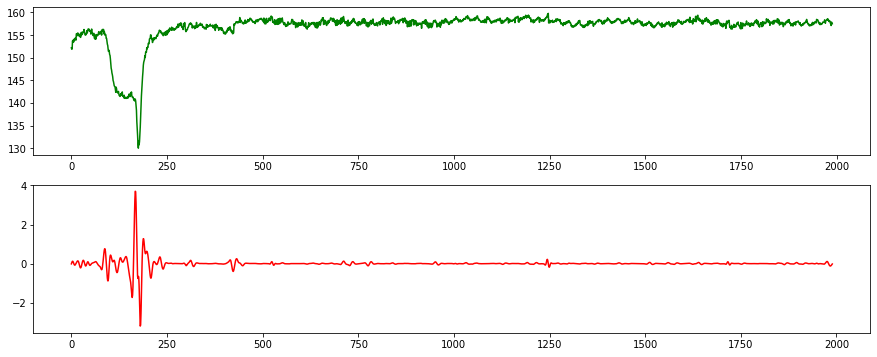

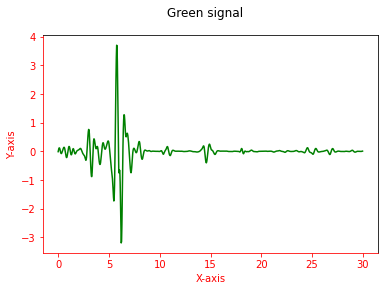

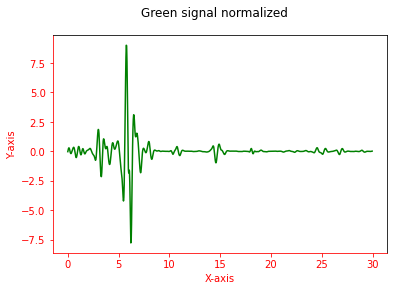

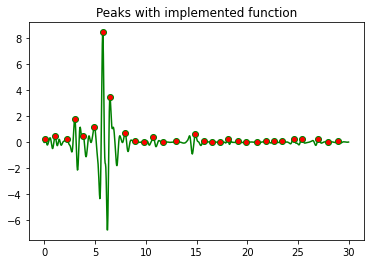

[2021-08-01 19:59:31,739] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 0.10344828  1.06896552  2.20689655  3.          3.82758621  4.93103448
  5.75862069  6.48275862  7.96551724  8.93103448  9.82758621 10.75862069
 11.68965517 12.96551724 14.89655172 15.72413793 16.55172414 17.31034483
 18.06896552 19.03448276 19.82758621 20.93103448 21.79310345 22.5862069
 23.44827586 24.55172414 25.34482759 27.         27.96551724 28.96551724] num of peaks: 30


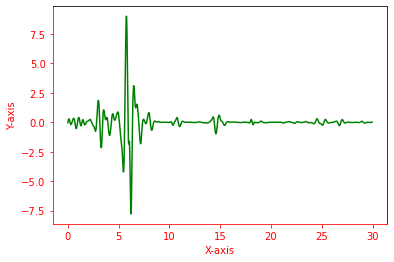

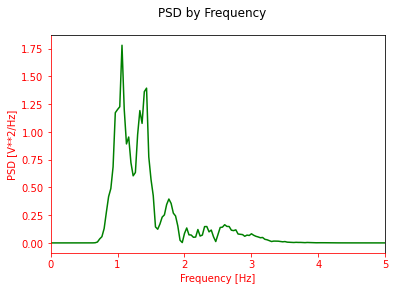

[2021-08-01 19:59:31,953] [INFO] [find_hr_in_window] [34] : Window 0:
Highest freq:1.0666666666666667
Heart rate: 64.0


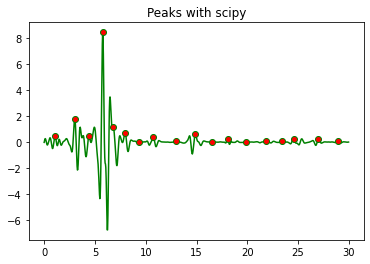

[2021-08-01 19:59:32,061] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 31  87 128 167 197 231 271 312 376 432 480 524 575 632 680 712 783 840] num of peaks: 18


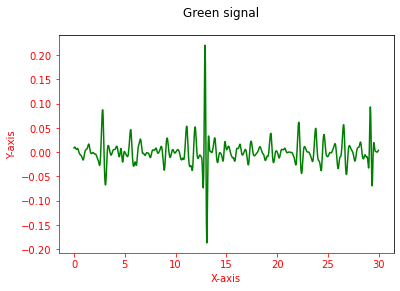

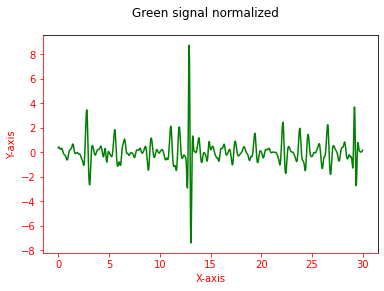

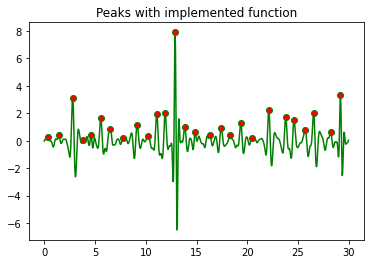

[2021-08-01 19:59:32,361] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 0.37931034  1.44827586  2.79310345  3.86206897  4.62068966  5.5862069
  6.51724138  7.75862069  9.13793103 10.24137931 11.10344828 11.93103448
 12.89655172 13.86206897 14.86206897 16.31034483 17.4137931  18.31034483
 19.37931034 20.44827586 22.10344828 23.79310345 24.5862069  25.68965517
 26.51724138 28.20689655 29.17241379] num of peaks: 27


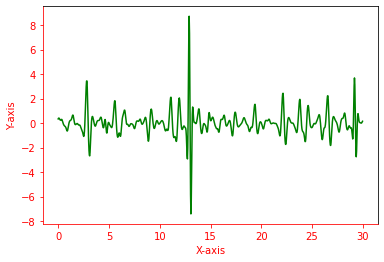

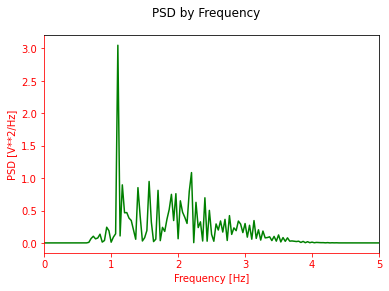

[2021-08-01 19:59:32,558] [INFO] [find_hr_in_window] [34] : Window 1:
Highest freq:1.1
Heart rate: 66.0


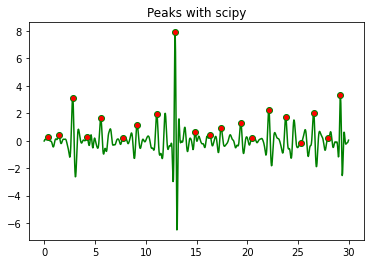

[2021-08-01 19:59:32,640] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 11  42  81 122 162 225 265 322 374 431 473 505 562 593 641 690 732 769
 810 846] num of peaks: 20


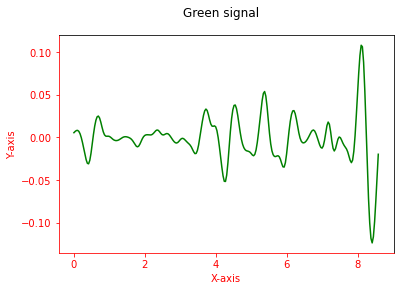

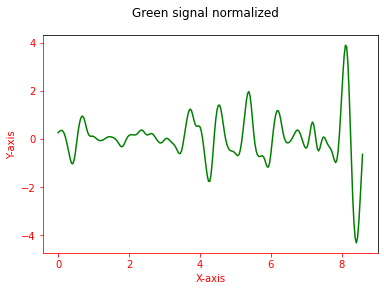

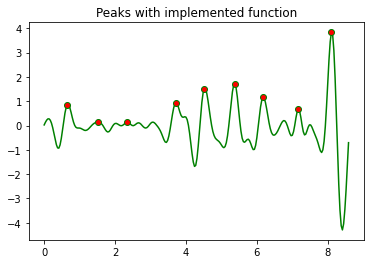

[2021-08-01 19:59:32,895] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [0.65517241 1.51724138 2.34482759 3.72413793 4.51724138 5.37931034
 6.17241379 7.17241379 8.10344828] num of peaks: 9


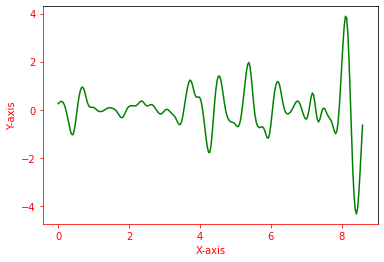

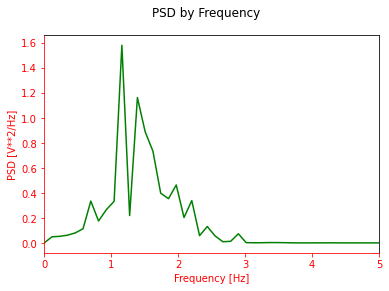

[2021-08-01 19:59:33,155] [INFO] [find_hr_in_window] [34] : Window 2:
Highest freq:1.1600000000000001
Heart rate: 69.60000000000001


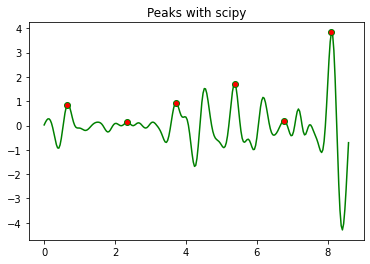

[2021-08-01 19:59:33,287] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 19  68 108 156 196 235] num of peaks: 6
[2021-08-01 19:59:33,288] [INFO] [<module>] [8] : Working on video C:\Users\eyalg\Downloads\dataset\subject4\vid.avi
[2021-08-01 19:59:33,294] [INFO] [<module>] [14] : Parsing images ...
[2021-08-01 19:59:33,296] [INFO] [<module>] [25] : Parsing frame 0/2028.0
[2021-08-01 20:00:25,741] [INFO] [<module>] [25] : Parsing frame 100/2028.0
[2021-08-01 20:01:22,069] [INFO] [<module>] [25] : Parsing frame 200/2028.0
[2021-08-01 20:02:17,201] [INFO] [<module>] [25] : Parsing frame 300/2028.0
[2021-08-01 20:02:59,245] [INFO] [<module>] [25] : Parsing frame 400/2028.0
[2021-08-01 20:03:43,540] [INFO] [<module>] [25] : Parsing frame 500/2028.0
[2021-08-01 20:04:30,948] [INFO] [<module>] [25] : Parsing frame 600/2028.0
[2021-08-01 20:05:22,228] [INFO] [<module>] [25] : Parsing frame 700/2028.0
[2021-08-01 20:06:17,206] [INFO] [<module>] [25] : Parsing frame 800/2028.0

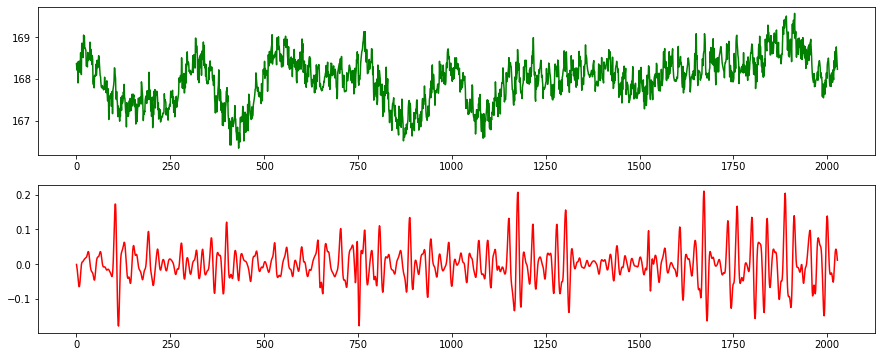

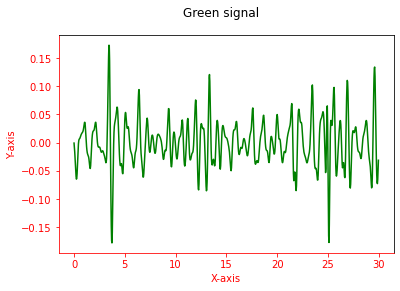

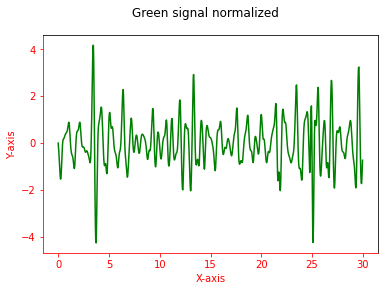

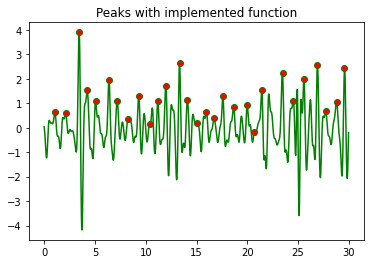

[2021-08-01 20:16:54,584] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 1.06666667  2.13333333  3.43333333  4.23333333  5.06666667  6.4
  7.2         8.3         9.3        10.4        11.2        11.96666667
 13.33333333 14.1        15.06666667 15.96666667 16.73333333 17.6
 18.66666667 20.         20.7        21.43333333 23.46666667 24.53333333
 25.56666667 26.9        27.73333333 28.8        29.56666667] num of peaks: 29


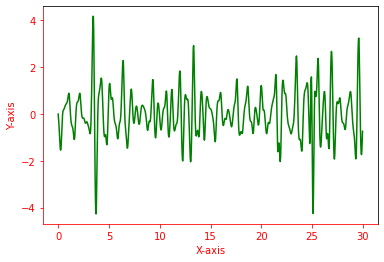

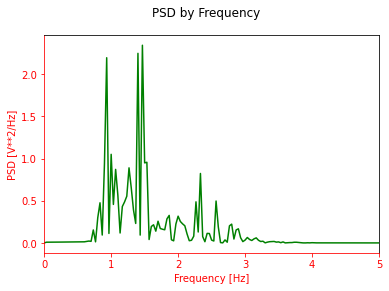

[2021-08-01 20:16:54,789] [INFO] [find_hr_in_window] [34] : Window 0:
Highest freq:1.4666666666666666
Heart rate: 88.0


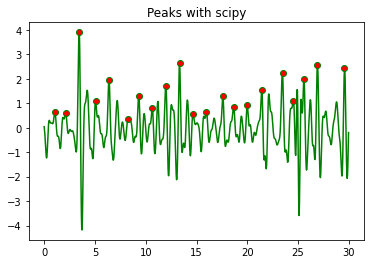

[2021-08-01 20:16:54,870] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 32  64 103 152 192 249 279 319 359 400 440 479 528 560 600 643 704 736
 767 807 887] num of peaks: 21


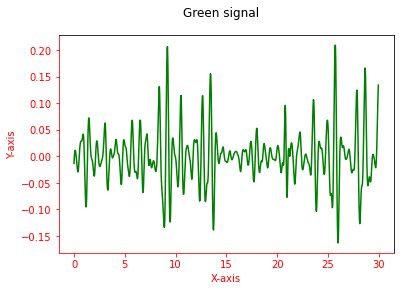

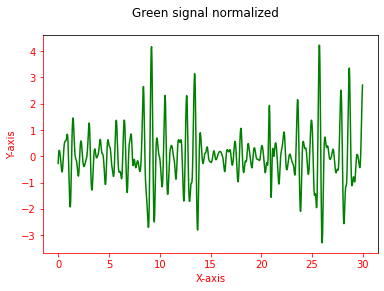

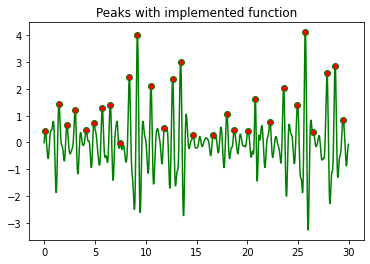

[2021-08-01 20:16:55,269] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [ 0.1         1.46666667  2.23333333  3.06666667  4.13333333  4.9
  5.73333333  6.5         7.5         8.4         9.16666667 10.53333333
 11.83333333 12.66666667 13.43333333 14.66666667 16.63333333 18.
 18.73333333 20.06666667 20.8        22.23333333 23.56666667 24.93333333
 25.7        26.5        27.83333333 28.66666667 29.43333333] num of peaks: 29


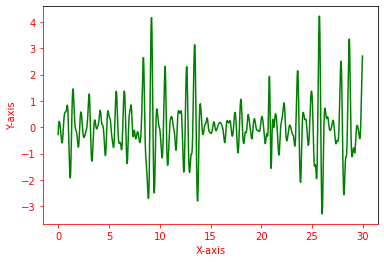

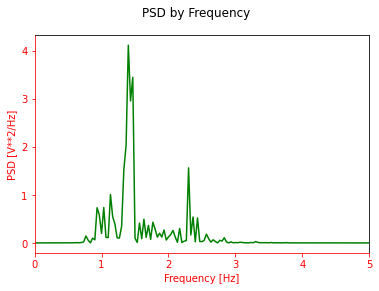

[2021-08-01 20:16:55,508] [INFO] [find_hr_in_window] [34] : Window 1:
Highest freq:1.4
Heart rate: 84.0


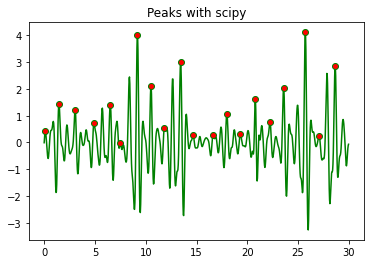

[2021-08-01 20:16:55,610] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [  3  44  92 147 195 225 275 316 355 403 440 499 540 579 624 667 707 771
 812 860] num of peaks: 20


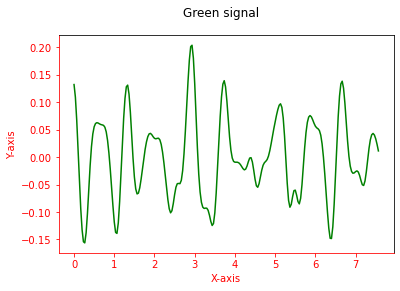

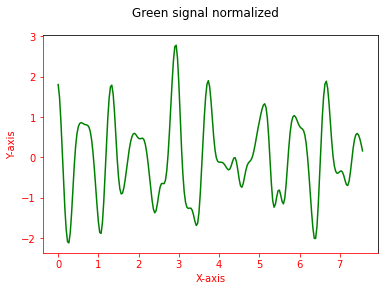

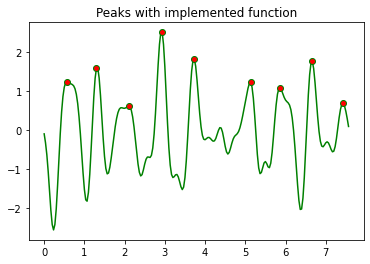

[2021-08-01 20:16:55,884] [INFO] [print_peaks] [61] : Peaks vector by implemented function: [0.56666667 1.3        2.1        2.93333333 3.73333333 5.13333333
 5.86666667 6.66666667 7.43333333] num of peaks: 9


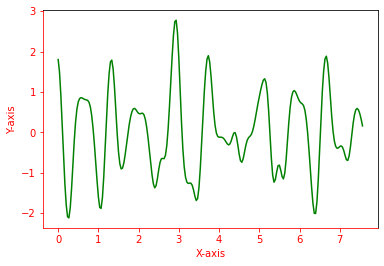

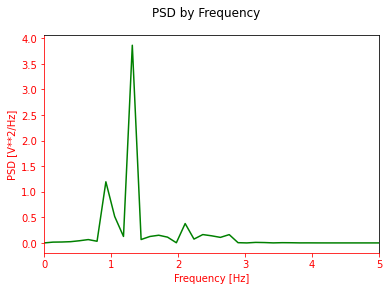

[2021-08-01 20:16:56,096] [INFO] [find_hr_in_window] [34] : Window 2:
Highest freq:1.3157894736842104
Heart rate: 78.94736842105263


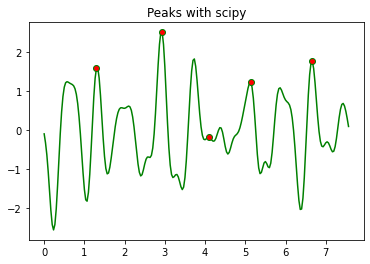

[2021-08-01 20:16:56,161] [INFO] [print_peaks_with_scipy] [46] : Peaks vector with scipy: [ 39  88 123 154 200] num of peaks: 5


In [15]:
# Parsing video:
for video_location in video_sources:
    color_sig = [[],[]]
    heart_rates = []
    good_frame_number = 0
#     total_frame_number = 180
    total_frame_number = 0
    logging.info("Working on video " + video_location)
    vidcap = cv2.VideoCapture(video_location)
    success, image = vidcap.read()
    fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
    round_fps = np.round(fps)
    number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    logging.info("Parsing images ...")
    skipped_frames = 0
    bad_frames = 0
    max_luminance = 0
    min_luminance = 200
    avg_luminance = 0
    perv_luminance = None
    max_diff_luminance_adjacent = 0

    while success:
        if total_frame_number % 100 == 0:
            logging.info("Parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
        rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
        if rois is not None :
            try:
                is_good_frame,color_sig, luminance_level = parse_RGB(rois, color_sig) # add mean value of the  green channel in the current frame to the signal 
                if perv_luminance is not None and luminance_level - perv_luminance > max_diff_luminance_adjacent:
                    max_diff_luminance_adjacent = luminance_level - perv_luminance
                if luminance_level > max_luminance:
                    max_luminance = luminance_level
                if luminance_level < min_luminance:
                    min_luminance = luminance_level
                avg_luminance += luminance_level
                perv_luminance = luminance_level
            except Exception as e:
                logging.error("failed to get output from parse_RGB!\nError:" + str(e))
                is_good_frame = False
                bad_frames += 1
            if is_good_frame:
                good_frame_number += 1
                #logging.info("luminance level: " + str(luminance_level))
        if rois is None:
            bad_frames += 1
        total_frame_number += 1
        success, image = get_new_frame(vidcap)
    avg_luminance /= total_frame_number
    log_video_details(video_location)
    try:
        detect_hr(video_location) # Display the HR
    except Exception as e:
        logging.warning("Issue in detecting hr in video: " + str(e))